In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='4'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=1,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-mask/",
    project_name="breakfast-split-1",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 1, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-mask/', 'project_name': 'breakfast-split-1', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split1.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split1.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_sp

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1460
Number of videos not found in train fold is 0
Number of videos logged in test fold is 252
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames
selected_frames_dict = None

In [12]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-slup15/ms-tcn-initial-25-epochs.wt")
model.load_state_dict(loaded_file)

<All keys matched successfully>

In [21]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [23]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [24]:
def get_boundary(labels_arr):
    unique_ids = []

    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele

    unique_ids.append(len(labels_arr) - 1)
    return unique_ids

def get_boundary_from_pseudo_data(psuedo_dir):
    boundary_dict = {}
    for filename in glob.glob(psuedo_dir + "/*.txt"):
        video_id = filename.split("/")[-1]
        data = open(filename).read().split("\n")[0:-1]
        data = np.array(data)
        boundary = get_boundary(data)
        boundary_dict[video_id.split(".txt")[0]] = boundary
    return boundary_dict


In [31]:
import copy
def change_selected_frames(model):
    global selected_frames_dict
    new_selected_frame_dict = {}
    if selected_frames_dict is None:
        estimated_boundary_dict = get_boundary_from_pseudo_data(pseudo_labels_dir)
    else:
        estimated_boundary_dict = get_estimated_boundaries()
    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)

            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                
                estimated_boundary = estimated_boundary_dict[video_id]
                estimated_boundary.append(item[1][idx].item())
                start_mark = 0
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    expected_value_of_class = torch.argmax(prob_class[start_mark: estimated_boundary[i] + 1]).item() \
                                                + start_mark

                    if i > 0 and expected_value_of_class <= new_index_label_pair_list[-1][0]:
                        print(f"start_mark = {start_mark}, Boundary End = {estimated_boundary[i] + 1}"+
                             f"Expected argmax = {expected_value_of_class}")
                        print(new_index_label_pair_list)
                        print(i)
                        print(estimated_boundary)
                        import pdb
                        pdb.set_trace()
                    new_index_label_pair_list.append((expected_value_of_class,
                                                      label_id_to_label_name[weakly_labels_video[i]]))
                    start_mark = expected_value_of_class + 1

                    
#                 final_list = new_index_label_pair_list
#                 is_valid_list = True
#                 for i in range(1, len(final_list) - 1, 1):
#                     cur_ele = final_list[i]
                    
#                     if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
#                         is_valid_list  = False

#                 if is_valid_list == False:
#                     print(f"Could not find expected solution for video {video_id}")
#                     print(final_list)
#                     import pdb
#                     pdb.set_trace()
                
                new_selected_frame_dict[video_id + ".txt"] = new_index_label_pair_list
                
        return new_selected_frame_dict

In [32]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [33]:
# selected_frames_dict = None
selected_frames_dict = change_selected_frames(model)
get_new_selected_frame_acc(selected_frames_dict)

Completed 0 videos selected frames calculation
Completed 10 videos selected frames calculation
Completed 20 videos selected frames calculation
Completed 30 videos selected frames calculation
Completed 40 videos selected frames calculation
Completed 50 videos selected frames calculation
Completed 60 videos selected frames calculation
Completed 70 videos selected frames calculation
Completed 80 videos selected frames calculation
Completed 90 videos selected frames calculation
Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Completed 160 videos selected frames calculation
Completed 170 videos selected frames calculation
Completed 180 videos selected frames calculation
Total correct pivots labels selected =  61.60849772382397


In [34]:
# Initialize Expection Boundaries
print("Calculating Expectation")
correct = 0.0
total = 0.0
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f"Completed iter {i}")

get_boundary_err()

Calculating Expectation
Completed iter 0
Completed iter 10
Completed iter 20
Completed iter 30
Completed iter 40
Completed iter 50
Completed iter 60
Completed iter 70
Completed iter 80
Completed iter 90
Completed iter 100
Completed iter 110
Completed iter 120
Completed iter 130
Completed iter 140
Completed iter 150
Completed iter 160
Completed iter 170
Completed iter 180
Train Boundary avergage error = 322.838
Train From boundary avergage accuracy = 59.585


In [35]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-mask/'

In [ ]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0

for epoch in range(51, 150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()
    
    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

#     if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0)):
    if ((epoch >= 50) and ((epoch % 25) == 0)):
        print("Updating selected frames again")
        torch.save(model.state_dict(), config.output_dir + f"ms-tcn-initial-{initialize_epoch}-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

#     if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
    if ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()



Starting Training
Training:: Epoch 51, Iteration 0, Current loss 0.2037858103562408 Accuracy 70.46898323324191
Training:: Epoch 51, Iteration 10, Current loss 0.2707902718869929 Accuracy 69.36304856238823
Training:: Epoch 51, Iteration 20, Current loss 0.23164370393474776 Accuracy 66.29654847326245
Training:: Epoch 51, Iteration 30, Current loss 0.1951396876877471 Accuracy 70.1696698671577
Training:: Epoch 51, Iteration 40, Current loss 0.19164065124915455 Accuracy 72.44441930191775
Training:: Epoch 51, Iteration 50, Current loss 0.18890983302525474 Accuracy 62.873314962389216
Training:: Epoch 51, Iteration 60, Current loss 0.20868513870220298 Accuracy 58.804920913884004
Training:: Epoch 51, Iteration 70, Current loss 0.18537585875234508 Accuracy 68.95187513548667
Training:: Epoch 51, Iteration 80, Current loss 0.19734552736002522 Accuracy 68.6042167066987
Training:: Epoch 51, Iteration 90, Current loss 0.20327750016208337 Accuracy 58.57477872758908
Training:: Epoch 51, Iteration 100, 

Training:: Epoch 55, Iteration 60, Current loss 0.18865869692143064 Accuracy 53.58575395601005
Training:: Epoch 55, Iteration 70, Current loss 0.14636221758513226 Accuracy 68.15308785155118
Training:: Epoch 55, Iteration 80, Current loss 0.16430312670408848 Accuracy 52.35964441262455
Training:: Epoch 55, Iteration 90, Current loss 0.13929604275940705 Accuracy 63.81178812341037
Training:: Epoch 55, Iteration 100, Current loss 0.17687271789618772 Accuracy 61.642129934812864
Training:: Epoch 55, Iteration 110, Current loss 0.20668940555851947 Accuracy 64.58513864818025
Training:: Epoch 55, Iteration 120, Current loss 0.23406303198827952 Accuracy 55.45247680728164
Training:: Epoch 55, Iteration 130, Current loss 0.17489265909647214 Accuracy 53.386744355426075
Training:: Epoch 55, Iteration 140, Current loss 0.15626137409442997 Accuracy 71.54190105293523
Training:: Epoch 55, Iteration 150, Current loss 0.16736892980007548 Accuracy 60.49035883028987
Training:: Epoch 55, Iteration 160, Curren

Training:: Epoch 59, Iteration 70, Current loss 0.15203175439084893 Accuracy 70.20263375285485
Training:: Epoch 59, Iteration 80, Current loss 0.19563525587182637 Accuracy 68.81208609271523
Training:: Epoch 59, Iteration 90, Current loss 0.1716835147848865 Accuracy 57.363164202956455
Training:: Epoch 59, Iteration 100, Current loss 0.19006723673806145 Accuracy 61.449547016557325
Training:: Epoch 59, Iteration 110, Current loss 0.19169835488330014 Accuracy 55.600928817359275
Training:: Epoch 59, Iteration 120, Current loss 0.1316165836564206 Accuracy 73.52986992756445
Training:: Epoch 59, Iteration 130, Current loss 0.2228919167055832 Accuracy 60.24362328319163
Training:: Epoch 59, Iteration 140, Current loss 0.13706317553777386 Accuracy 67.45577920097591
Training:: Epoch 59, Iteration 150, Current loss 0.16907525673614157 Accuracy 64.048847784988
Training:: Epoch 59, Iteration 160, Current loss 0.19196792888099706 Accuracy 64.6711166736198
Training:: Epoch 59, Iteration 170, Current lo

Training:: Epoch 63, Iteration 80, Current loss 0.13436843792909156 Accuracy 73.81866509155346
Training:: Epoch 63, Iteration 90, Current loss 0.17937289516992364 Accuracy 65.59911651021535
Training:: Epoch 63, Iteration 100, Current loss 0.18845440080704132 Accuracy 67.04882546300009
Training:: Epoch 63, Iteration 110, Current loss 0.21080254177301055 Accuracy 54.46100519930676
Training:: Epoch 63, Iteration 120, Current loss 0.16216461367731408 Accuracy 65.1551517229556
Training:: Epoch 63, Iteration 130, Current loss 0.20391137242818358 Accuracy 65.75621687729311
Training:: Epoch 63, Iteration 140, Current loss 0.18729224867547897 Accuracy 66.02818937477413
Training:: Epoch 63, Iteration 150, Current loss 0.15022853470018216 Accuracy 68.59601865843243
Training:: Epoch 63, Iteration 160, Current loss 0.238594644027659 Accuracy 57.094868527742385
Training:: Epoch 63, Iteration 170, Current loss 0.16156603957922652 Accuracy 66.25957222075522
Training:: Epoch 63, Iteration 180, Current 

Training:: Epoch 67, Iteration 90, Current loss 0.19877558058617495 Accuracy 66.5690223361406
Training:: Epoch 67, Iteration 100, Current loss 0.22226328028744655 Accuracy 49.9607958443595
Training:: Epoch 67, Iteration 110, Current loss 0.2312343474496183 Accuracy 65.19323219079727
Training:: Epoch 67, Iteration 120, Current loss 0.24757808844582005 Accuracy 68.48065303509263
Training:: Epoch 67, Iteration 130, Current loss 0.1805278646545052 Accuracy 66.18219272144655
Training:: Epoch 67, Iteration 140, Current loss 0.2366229826046069 Accuracy 72.38187588152327
Training:: Epoch 67, Iteration 150, Current loss 0.2023154989051436 Accuracy 67.75443204202233
Training:: Epoch 67, Iteration 160, Current loss 0.18725056566732698 Accuracy 61.733581494283435
Training:: Epoch 67, Iteration 170, Current loss 0.3028070138371494 Accuracy 64.51695131277084
Training:: Epoch 67, Iteration 180, Current loss 0.19587254191920475 Accuracy 57.73144700918342
Calculating Validation Data Accuracy
Validation

Training:: Epoch 71, Iteration 100, Current loss 0.21151469893466937 Accuracy 63.190184049079754
Training:: Epoch 71, Iteration 110, Current loss 0.162703714827333 Accuracy 69.51455601417248
Training:: Epoch 71, Iteration 120, Current loss 0.23780158698020848 Accuracy 69.72001577375923
Training:: Epoch 71, Iteration 130, Current loss 0.22664519439493158 Accuracy 66.05315520181921
Training:: Epoch 71, Iteration 140, Current loss 0.16766160768252852 Accuracy 76.52291408625155
Training:: Epoch 71, Iteration 150, Current loss 0.2117825442191635 Accuracy 59.09009428888969
Training:: Epoch 71, Iteration 160, Current loss 0.16678846327692515 Accuracy 62.58925314014697
Training:: Epoch 71, Iteration 170, Current loss 0.19334276334376319 Accuracy 67.95872033023736
Training:: Epoch 71, Iteration 180, Current loss 0.13611191840459091 Accuracy 67.36766321852147
Calculating Validation Data Accuracy
Validation:: Epoch 71, Probability Accuracy 57.291728496187346
Starting Training
Training:: Epoch 72,

Training:: Epoch 75, Iteration 160, Current loss 0.12943666473842758 Accuracy 51.480851562958186
Training:: Epoch 75, Iteration 170, Current loss 0.1416241316318359 Accuracy 64.08868632198642
Training:: Epoch 75, Iteration 180, Current loss 0.25212866378758847 Accuracy 66.93910096680953
Calculating Validation Data Accuracy
Validation:: Epoch 75, Probability Accuracy 56.766820597441345
Updating selected frames again
Completed 0 videos selected frames calculation
Completed 10 videos selected frames calculation
Completed 20 videos selected frames calculation
Completed 30 videos selected frames calculation
Completed 40 videos selected frames calculation
Completed 50 videos selected frames calculation
Completed 60 videos selected frames calculation
Completed 70 videos selected frames calculation
Completed 80 videos selected frames calculation
Completed 90 videos selected frames calculation
Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Comp

In [32]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 130, Probability Accuracy 51.43919338691232


In [33]:
best_val_acc

54.61000906173455

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

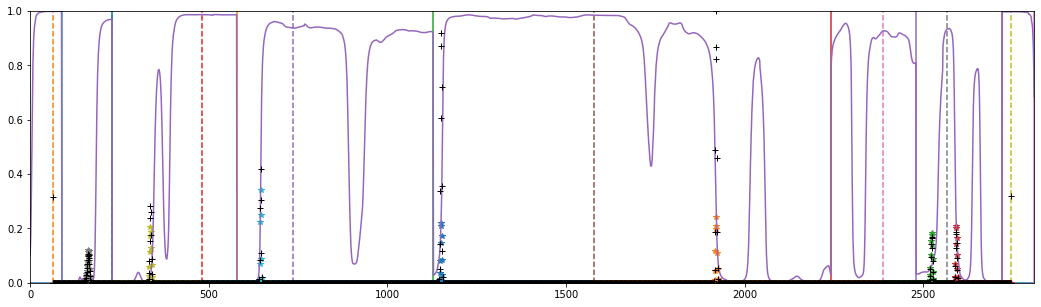

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

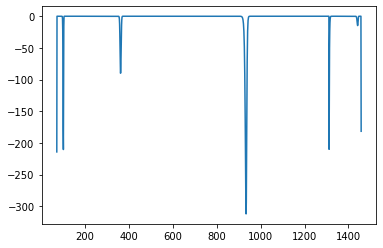

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

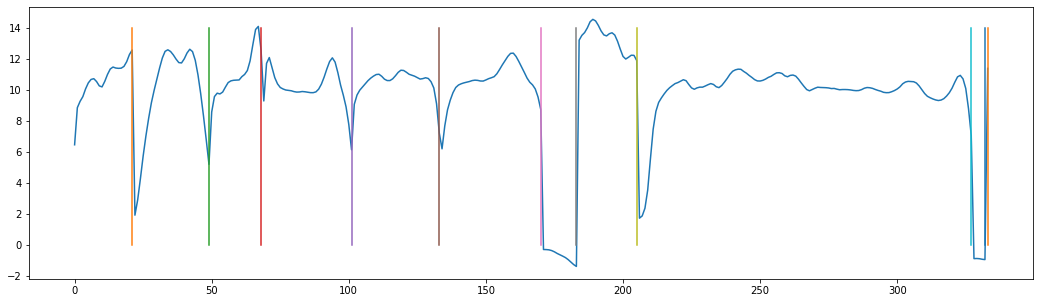

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])